# Instrucciones 

redacta un código que calcule tres portafolios óptimos con 5 índices accionarios globales (o acciones) denominados en pesos mexicanos de tu elección, donde estos portafolios optimos deben alacanzar un retorno de 10% anual.
Mninmizar varianza
Maximizar sharpe ratio
Toma datos de 2010 a 2020, el código tiene que extraer los datos de yahoo finance. Compara el performance de tus portafolios optimos contra el S&P500 para el plazo de 2021 a la fecha y concluye donde hubiera sido mejor invertir (en tus portafolios o en el S&P500)

# obtención de los datos y cálculo del stuff necesario para llevar a cabo el análisis

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco
from scipy.optimize import minimize
from datetime import datetime, timedelta
import cvxpy as cp
import requests

In [148]:
# Las 5 acciones que se seleccionaron fueron: NVIDIA, GOOGLE, MASTERCARD, ADOBE y AMAZON.
tickers = ['NVDA', 'GOOGL', 'MA', 'MELI', 'AMD']

# obtenemos los precios con la paquetería yahoofinance en las fechas ind
def obtain_prices(tickers, fecha1, fecha2):
    prices_df = pd.DataFrame()
    for symbol in tickers:
        data = yf.download(symbol, start = fecha1, end = fecha2)
        prices_df[symbol] = data['Adj Close']
    return prices_df

prices_df = obtain_prices(tickers, '2010-01-01', '2020-12-31')
prices_df.index = pd.to_datetime(prices_df.index)
lista_fechasp = pd.to_datetime(prices_df.index)
prices_df.index = [lista_fechasp[i].date() for i in range(len(lista_fechasp))]

prices_df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,NVDA,GOOGL,MA,MELI,AMD
2010-01-04,4.241589,15.684434,23.960316,49.021599,9.700000
2010-01-05,4.303529,15.615365,23.889414,50.271603,9.710000
2010-01-06,4.331054,15.221722,23.854876,49.680523,9.570000
2010-01-07,4.246178,14.867367,23.698992,48.701828,9.470000
2010-01-08,4.255352,15.065566,23.707394,48.944073,9.430000
...,...,...,...,...,...
2020-12-23,129.835495,86.411499,324.677429,1670.010010,91.550003
2020-12-24,129.680786,86.708000,331.353790,1690.479980,91.809998
2020-12-28,128.745148,88.697998,339.706696,1663.719971,91.599998
2020-12-29,129.176788,87.888000,341.866364,1673.489990,90.620003


In [149]:
# La siguiente función permite obtener datos consumiendo el API de Banxico
def datos_banxico(fecha_inicial, fecha_final, serie):
    fecha_inicial = fecha_inicial
    fecha_final = fecha_final
    serie = serie
    token = '1c17991d7e9c8da5148271c00102745c4ec12f5a2bb6794d5c13ab0f080f5085'
    url = 'https://www.banxico.org.mx/SieAPIRest/service/v1/series/{}/datos/{}/{}'.format(serie,fecha_inicial,fecha_final)
    result = requests.get(url, headers={'Content-Type':'application/json','Bmx-Token': token})
    if result.status_code == 200:
        df = pd.DataFrame(result.json()['bmx']['series'][0]['datos'])
        df['ID_Serie'] = result.json()['bmx']['series'][0]['idSerie']
        df['Serie'] = result.json()['bmx']['series'][0]['titulo']
    else:
        df = ''

    return df

In [150]:
# usando la función datos_banxico() para obtener los datos del tipo de cambio en las fechas de interés
fix = datos_banxico('2010-01-01', '2023-05-25','SF43718')
fix = fix.drop(['ID_Serie', 'Serie'], axis=1)
fix.columns = ['Date', 'mxn/usd']
fix['Date'] = pd.to_datetime(fix['Date'], format='%d/%m/%Y').dt.strftime('%Y-%m-%d')
fix.set_index('Date', inplace=True)
lista_fechasfix = pd.to_datetime(fix.index)
fix.index = [lista_fechas[i].date() for i in range(len(lista_fechasfix))]
fix['mxn/usd'] = fix['mxn/usd'].astype(float)
fix

,mxn/usd
2010-01-04,12.9226
2010-01-05,12.8241
2010-01-06,12.7489
2010-01-07,12.7646
2010-01-08,12.7243
...,...
2023-05-19,17.6930
2023-05-22,17.8680
2023-05-23,17.9687
2023-05-24,17.8195


In [151]:
# Se realiza la conversión del cierre del precio de las acciones a pesos mexicanos con la información de Banxico 
df = pd.concat([prices_df, fix], axis=1)
df = df.dropna()
prices_df = pd.DataFrame({'MELI': df['MELI']*df['mxn/usd'],'AMD': df['AMD']*df['mxn/usd'],'MA': df['MA']*df['mxn/usd'],'NVDA': df['NVDA']*df['mxn/usd'], 'GOOGL': df['GOOGL']*df['mxn/usd']})
prices_df

,MELI,AMD,MA,NVDA,GOOGL
2010-01-04,633.486513,125.349218,309.629576,54.812353,202.683666
2010-01-05,644.688059,124.522011,306.360232,55.188884,200.253003
2010-01-06,633.372019,122.006969,304.123423,55.216177,194.060207
2010-01-07,621.659354,120.880765,302.508150,54.200766,189.775990
2010-01-08,622.779065,119.990153,301.659989,54.146382,191.698782
...,...,...,...,...,...
2020-12-23,33596.426371,1841.757186,6531.698182,2611.965571,1738.383332
2020-12-24,33558.901428,1822.584529,6577.936039,2574.384062,1721.301207
2020-12-28,33353.758857,1836.369289,6810.337921,2581.044098,1778.190855
2020-12-29,33383.949768,1807.751249,6819.789526,2576.908997,1753.251355


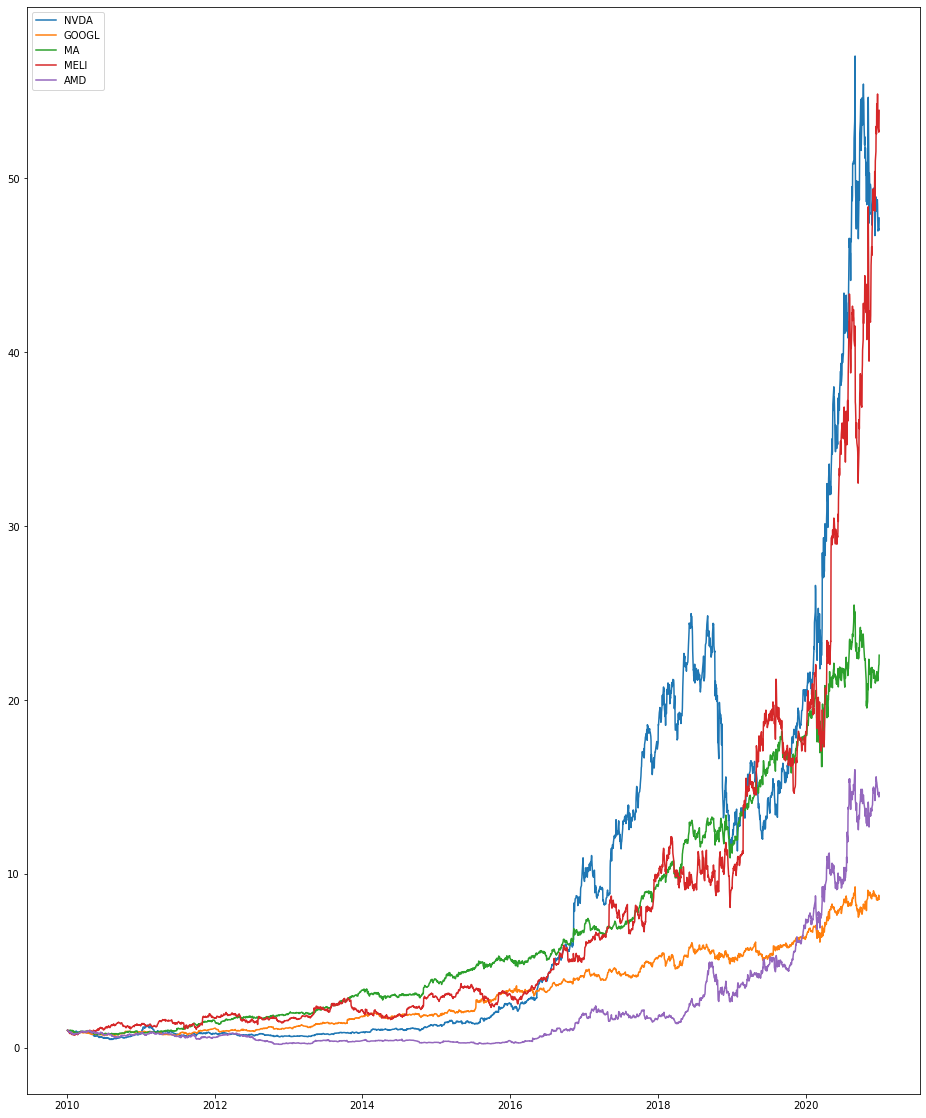

In [152]:
# La gráfica del comportamiento de los precios de las acciones seleccionadas a través del tiempo:
(prices_df[tickers] / prices_df[tickers].iloc[0]).plot(figsize=(16, 20));

In [153]:
# Se calculan los retornos diarios de cada stock
Rij = ((prices_df / prices_df.shift(1)) - 1).dropna()
Rij

,MELI,AMD,MA,NVDA,GOOGL
2010-01-05,0.017682,-0.006599,-0.010559,0.006869,-0.011992
2010-01-06,-0.017553,-0.020198,-0.007301,0.000495,-0.030925
2010-01-07,-0.018493,-0.009231,-0.005311,-0.018390,-0.022077
2010-01-08,0.001801,-0.007368,-0.002804,-0.001003,0.010132
2010-01-11,-0.100132,-0.034950,-0.020717,-0.018286,-0.005835
...,...,...,...,...,...
2020-12-23,-0.033062,-0.014279,-0.006031,-0.017264,0.007727
2020-12-24,-0.001117,-0.010410,0.007079,-0.014388,-0.009826
2020-12-28,-0.006113,0.007563,0.035331,0.002587,0.033050
2020-12-29,0.000905,-0.015584,0.001388,-0.001602,-0.014025


In [154]:
# Se calculan los retornos esperados de cada acción

expected_Ri = Rij.sum() / len(prices_df.index)
expected_Ri

MELI     0.001860
AMD      0.001626
MA       0.001308
NVDA     0.001780
GOOGL    0.000928
dtype: float64

In [155]:
# Se calcula el riesgo de los stocks

aux_risk = ((Rij - expected_Ri)**2)
stock_risk = aux_risk.sum()/len(prices_df.index)
stock_risk

MELI     0.000773
AMD      0.001283
MA       0.000301
NVDA     0.000696
GOOGL    0.000264
dtype: float64

In [156]:
# Se anualizan los rendimientos de las acciones:

rendimiento_acumulado = (1 + Rij).cumprod()
n_dias = len(Rij)
Rij_an = (1 + rendimiento_acumulado) ** (252 / n_dias) - 1

# Se calcula el rendimiento esperado (anualizado) para cada acción:

expected_Riann = Rij_an.sum() / len(prices_df.index)
expected_Riann

MELI     0.176887
AMD      0.086308
MA       0.180509
NVDA     0.169366
GOOGL    0.129886
dtype: float64

In [166]:
infodf = pd.concat([expected_Riann, stock_risk], axis = 1)
infodf.columns = ['Retorno esperado', 'Riesgo']
infodf

,Retorno esperado,Riesgo
MELI,0.176887,0.000773
AMD,0.086308,0.001283
MA,0.180509,0.000301
NVDA,0.169366,0.000696
GOOGL,0.129886,0.000264


# Primer portafolio: varianza mínima
Vamos a hallar los pesos del portafolio que minimizan la varianza

In [167]:
m = np.array(expected_Riann)
m

array([0.17688748, 0.0863075 , 0.18050872, 0.16936559, 0.12988612])

In [168]:
# Se calcula la matriz de covarianza de los stocks 
Q = Rij_an.cov().to_numpy()
Q

array([[0.00959163, 0.00662577, 0.00837755, 0.01206118, 0.00528315],
       [0.00662577, 0.00532447, 0.00541812, 0.0084295 , 0.00338605],
       [0.00837755, 0.00541812, 0.0079045 , 0.01076581, 0.0050021 ],
       [0.01206118, 0.0084295 , 0.01076581, 0.01654522, 0.00701028],
       [0.00528315, 0.00338605, 0.0050021 , 0.00701028, 0.00325792]])

Se quiere hallar la solución ($w_i$'s) del problema de optimización:
\
$min_w \ w^TQw$   sujeto a    $\sum_{i}w_i = 1, \ 0\leq w_i$

In [169]:
n = Rij_an.shape[1]
w = cp.Variable(n)

# usando minimize de la librería cvxpy
restricciones = [sum(w) == 1 , w >= 0.01, w <= 0.5]
probmin = cp.Problem(cp.Minimize(cp.quad_form(w, Q)) , restricciones)
probmin.solve(verbose=False)

0.003957151451429719

In [170]:
# El vector de pesos que minimiza la varianza:

w_minvar = w.value
w_minvar

array([0.01, 0.47, 0.01, 0.01, 0.5 ])

In [171]:
# Calculando la varianza del portafolio
var_pmv = np.dot(w_minvar, np.dot(Q, w_minvar))
var_pmv

0.003957151451429719

In [172]:
# Calculando el retorno esperado del portafolio con los pesos que minimizan la varianza: 
ret_pmv = np.dot(m, w_minvar)
ret_pmv

0.11077520474128993

In [173]:
port_min_var = infodf
port_min_var['peso (%)'] = w_minvar*100
port_min_var

,Retorno esperado,Riesgo,peso (%)
MELI,0.176887,0.000773,1.0
AMD,0.086308,0.001283,47.0
MA,0.180509,0.000301,1.0
NVDA,0.169366,0.000696,1.0
GOOGL,0.129886,0.000264,50.0


# Segundo portafolio: Sharpe ratio máximo
Vamos a hallar los pesos del portafolio que maximizan el Sharpe ratio

In [174]:
wmax = cp.Variable(n)

# Objective
ret = m.T @ wmax
risk = cp.quad_form(wmax, Q)
alpha = 0.5
objective = cp.Maximize(ret - alpha*cp.norm(cp.matmul(Q,wmax), p=2))

# Constraints
constraints = [cp.sum(wmax) == 1, wmax >= 0.01, wmax <= 0.5]

# Solve problem
problem = cp.Problem(objective, constraints)
problem.solve()

0.1680687725908116

In [175]:
# El vector de pesos que maximiza el Sharpe Ratio:
w_maxsharpe = wmax.value
w_maxsharpe

array([0.47, 0.01, 0.5 , 0.01, 0.01])

In [178]:
# Calculando la varianza del portafolio
var_msr = np.dot(w_maxsharpe, np.dot(Q, w_maxsharpe))
var_msr

0.00847582050630213

In [179]:
# Calculando el retorno esperado del portafolio con los pesos que minimizan la varianza: 
ret_msr = np.dot(m, w_maxsharpe)
ret_msr

0.17724706911755558

In [180]:
port_max_SR = infodf
port_max_SR['peso (%)'] = w_maxsharpe*100
port_max_SR

,Retorno esperado,Riesgo,peso (%)
MELI,0.176887,0.000773,47.0
AMD,0.086308,0.001283,1.0
MA,0.180509,0.000301,50.0
NVDA,0.169366,0.000696,1.0
GOOGL,0.129886,0.000264,1.0


# Simulación

A continuación se simulan 1000000 portafolio para ver gráficamente la relación entre volatilidad esperada y retorno esperado

In [181]:
N_PORTFOLIOS = 10 ** 5
n_assets = len(Rij.columns)

# Simulando los pesos del portafolio
np.random.seed(42)
weights = np.random.random(size=(N_PORTFOLIOS, n))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]

In [182]:
retornos = []
vols = []


for i in range(len(weights)):
    retorno = np.dot(weights[i], expected_Riann)
    vol = np.dot(weights[i], np.dot(Q, weights[i])) 
    retornos.append(retorno)
    vols.append(vol)
    
sharpe_ratio = [retornos[i] / vols[i] for i in range(len(vols))]

In [183]:
portf_results_df = pd.DataFrame({'retorno': pd.Series(retornos), 'volatilidad': pd.Series(vols),'sharpe_ratio': pd.Series(sharpe_ratio)})
portf_results_df

,retorno,volatilidad,sharpe_ratio
0,0.142996,0.007812,18.304491
1,0.160178,0.007765,20.628400
2,0.134046,0.006371,21.039478
3,0.152345,0.007935,19.199589
4,0.157718,0.007888,19.994761
...,...,...,...
99995,0.142419,0.006772,21.030650
99996,0.139997,0.007180,19.498819
99997,0.156092,0.008311,18.781174
99998,0.141453,0.006865,20.604957


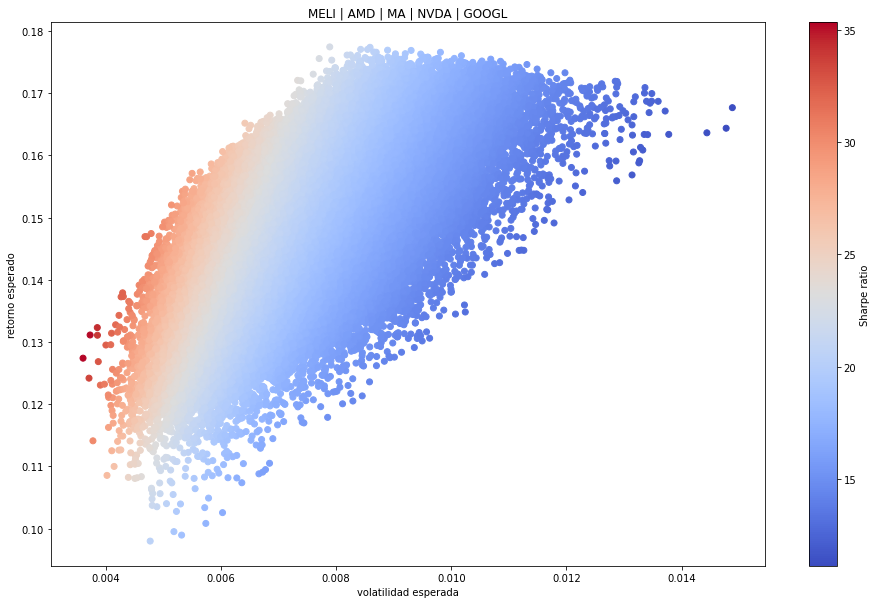

In [184]:
# graficando los resultados de la simulación:
plt.figure(figsize=(16, 10))
fig = plt.scatter(portf_results_df['volatilidad'], portf_results_df['retorno'],
c=portf_results_df['sharpe_ratio'], cmap='coolwarm')
cb = plt.colorbar(fig)
cb.set_label('Sharpe ratio')
plt.xlabel('volatilidad esperada')
plt.ylabel('retorno esperado')
plt.title(' | '.join(Rij.columns));

# Testing 
A continuación vamos a ver el rendimiento de los portafolios obtenidos y a comparlos con los rendimintos del S&P500

In [188]:
tickers_test = ['NVDA', 'GOOGL', 'MA', 'MELI', 'AMD', '^GSPC']
prices_testi = obtain_prices(tickers_test, '2021-01-01', '2023-05-25')
prices_test = pd.concat([prices_testi.head(1), prices_testi.tail(1)])
prices_test.index = pd.to_datetime(prices_test.index)
lista_fechast = pd.to_datetime(prices_test.index)
prices_test.index = [lista_fechast[i].date() for i in range(len(lista_fechast))]

prices_test

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,NVDA,GOOGL,MA,MELI,AMD,^GSPC
2021-01-04,130.875931,86.306503,346.629578,1640.000000,92.300003,3700.649902
2023-05-24,305.380005,120.900002,368.500000,1284.130005,108.269997,4115.240234


In [192]:
df = pd.concat([prices_test, fix], axis=1)
df = df.dropna()
df

,NVDA,GOOGL,MA,MELI,AMD,^GSPC,mxn/usd
2021-01-04,130.875931,86.306503,346.629578,1640.000000,92.300003,3700.649902,19.8457
2023-05-24,305.380005,120.900002,368.500000,1284.130005,108.269997,4115.240234,17.8195


In [193]:
ptest = pd.DataFrame({'S&P500': df['^GSPC']*df['mxn/usd'], 'MELI': df['MELI']*df['mxn/usd'],'AMD': df['AMD']*df['mxn/usd'],'MA': df['MA']*df['mxn/usd'],'NVDA': df['NVDA']*df['mxn/usd'], 'GOOGL': df['GOOGL']*df['mxn/usd']})
ptest

,S&P500,MELI,AMD,MA,NVDA,GOOGL
2021-01-04,73441.987767,32546.948000,1831.758171,6879.106609,2597.324460,1712.812972
2023-05-24,73331.523356,22882.554622,1929.317205,6566.485750,5441.718997,2154.377577


In [204]:
# Calculando los rendimientos de las acciones de 2021 a la fecha para todas las acciones
rend = ((ptest / ptest.shift(1)) - 1).dropna()
rend

,S&P500,MELI,AMD,MA,NVDA,GOOGL
2023-05-24,-0.001504,-0.296937,0.05326,-0.045445,1.095125,0.257801


In [208]:
# si se hubiesen invertido 100 mxn en el S&P500 a principios de 2021, hoy se tendrían:
(100 + 100*rend['S&P500'].values)[0]

99.84958956877831

In [209]:
# si se hubiesen invertido 100 mxn en el portafolio que minimiza la varianza a principios de 2021, hoy se tendrían:

monto_invertido = 100
rend_stocks = rend.drop('S&P500', axis=1)
100 + (w_minvar * monto_invertido*rend_stocks.values).sum()

116.14599391265136

In [210]:
# si se hubiesen invertido 100 mxn en el portafolio que maximiza el Sharpe Ratio a principios de 2021, hoy se tendrían:

100 + (w_maxsharpe * monto_invertido*rend_stocks.values).sum()

85.17789715284069

# Conclusión
Dados los rendimientos observados, concluimos que la mejor opción de inversión hubiese sido el portafolio con varianza mínima. Invertir en el S&P500 era mejor opción que invertir en el portafolio que maximizaba el Sharpe Ratio a finales de 2020.